In [1]:
import Heston
import BlackScholes
import pandas as pd
import numpy as np
import QuantLib as ql
import datetime
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy.optimize import NonlinearConstraint
from scipy.optimize import least_squares
import scipy.integrate
import time

In [2]:
tck = 'SPY'
number = 13

def open_files(main_path, number, year) -> dict: 
    opt_chains = dict()
    last_month = ''
    for i in range(1, number+1):
        file_name = main_path + '/exp (' + str(i) + ').csv'
        aux = pd.read_csv(file_name, index_col = 0)[['expiryDate','c_Last','c_Bid','c_Ask', 'c_Volume', 'c_Openinterest', 'strike']]
        aux.columns = ['expiryDate','last','bid','ask', 'volume', 'openinterest', 'strike']
        
        expiration = aux.iloc[0].expiryDate.split()
        
        months = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6,
                 'Jul':7,'Aug':8, 'Sep':9 ,'Oct':10, 'Nov':11,'Dec':12}
        
        curr_month = months[expiration[0]]        
        if last_month == 12 and curr_month == 1:
            year += 1            
        last_month = curr_month 
        
        opt_chains[ql.Date(int(expiration[1]), curr_month, year)] = aux.drop(columns = 'expiryDate')
        del aux
        
    return opt_chains

In [3]:
opt_chains = open_files('SPY_OPT', number, 2022)
day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates()
tomorrow = datetime.datetime(2022, 9, 14)
today = ql.Date(13, 9, 2022)   # referencing starting date
r = 0.0291
q = 0.0154
S0 = 393.1000061035156
mat = list(opt_chains.keys())
df = opt_chains[mat[-1]]
T = (mat[-1] - today)/365
df['mid'] = (df['bid'] + df['ask'])/2
df = df[df['strike'] > S0]
# df = df[df['strike'] % 5 == 0]
# df = df[df['last'] < df['ask']]
# df = df[df['last'] > df['bid']]

K = np.array(df['strike']).flatten()
P = np.array(df['mid']).flatten() 
N = 64
L = 12
options_type = np.ones(len(K))

<IPython.core.display.Javascript object>


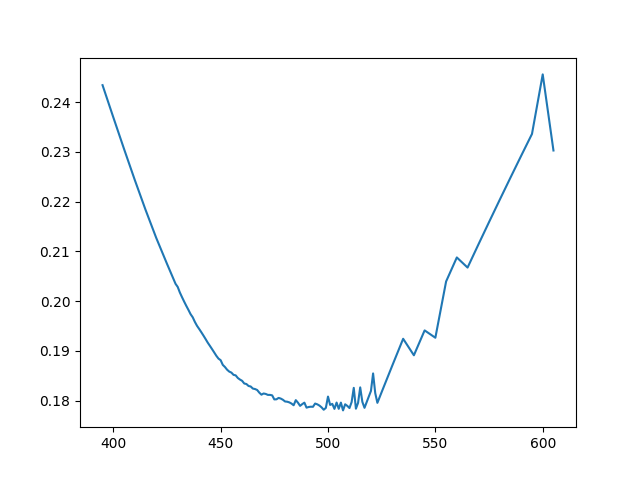

In [4]:
%matplotlib notebook
IV = BlackScholes.BSImpliedVol(S0, K, T, r, q, P, Option_type = 1, toll = 1e-10)
plt.plot(K,IV)
plt.show()

In [8]:
start_time = time.time()

params = np.array([.2, .5, .2, .3, -.8])

def f(prms):
    sigma_0, kappa,eta, theta, rho = prms
    precomp, a, b = Heston.precomputed_terms(r, q, T, sigma_0, kappa, eta, theta, rho, L, N)
    P_cal = Heston.cos_method_Heston_LF(precomp, a, b, T, r, q, sigma_0, kappa, eta, theta, \
                                        rho, S0, K, N, options_type, L)  
    err = P_cal - P
    return err

def j(prms):
    sigma_0, kappa,eta, theta, rho = prms
    return Heston.grad_c(T, K, sigma_0, kappa, eta, theta, rho, S0, r, q, 60, -1, 100)

bnds = ([1e-10,1e-10,1e-10,1e-10,-1.], [np.inf,np.inf,np.inf,np.inf,0.])
min_ = least_squares(f, x0 = params, bounds = bnds, jac = j, verbose = 2)
print(f'Time to run: {time.time() - start_time: .0f} s')

sigma_0, kappa, eta, theta, rho = min_.x
print(f'Calibrated parameters:\tkappa:{ kappa: .3f}\tsigma_0:{ sigma_0: .3f}\teta:{ eta: .3f}\ttheta:{ theta: .3f}\trho: {rho:.3f}')
P_cal = Heston.analytic_hest(S0, K, T, r, q, kappa, theta, rho, eta, sigma_0, options_type)
IV_cal = BlackScholes.BSImpliedVol(S0, K, T, r, q, P_cal, Option_type = 1, toll = 1e-5)

print(f'Feller condition: {2*kappa*eta - theta**2}')

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.5803e+03                                    6.57e+02    
       1              2         4.4212e+02      7.14e+03       9.68e-01       6.28e+02    
       2              5         4.2675e+01      3.99e+02       3.63e-02       1.09e+01    
       3              7         2.5724e+01      1.70e+01       3.97e-03       5.22e+00    
       4              9         2.2852e+01      2.87e+00       1.90e-03       2.85e+00    
       5             11         2.2691e+01      1.61e-01       9.30e-04       1.77e+00    
       6             23         2.2691e+01      0.00e+00       0.00e+00       1.77e+00    
`xtol` termination condition is satisfied.
Function evaluations 23, initial cost 7.5803e+03, final cost 2.2691e+01, first-order optimality 1.77e+00.
Time to run:  5 s
Calibrated parameters:	kappa: 0.029	sigma_0: 0.041	eta: 0.012	theta: 0.017	rho: -0.048
Feller condition: 

<IPython.core.display.Javascript object>


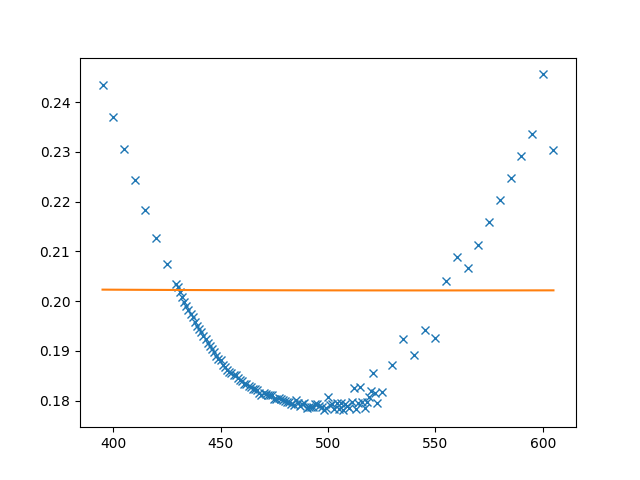

err = 0.8661876330304467	 err_IV = 0.0958841673800396


In [9]:
%matplotlib notebook

plt.plot(K,IV, 'x')
plt.plot(K,IV_cal)
plt.show()

err = np.linalg.norm((P-P_cal)/P, 1)/len(K)
err_IV = np.linalg.norm((IV-IV_cal)/IV, 1)/len(K)
print(f'err = {err}\t err_IV = {err_IV}')

<IPython.core.display.Javascript object>


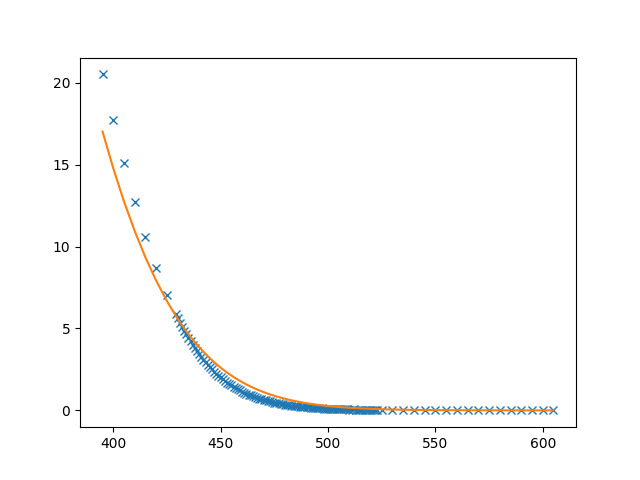

In [7]:
%matplotlib notebook

plt.plot(K,P, 'x')
plt.plot(K,P_cal)
plt.show()